### This notebook is for testing the Generalizability of our models on new public dataset on pig tissue
Images taken from 

Tiba, M.H., Mccracken, B.M., Leander, D.C., Colmenero, C.I., Nemzek, J.A., Sjoding, M.W., Konopka, K.E., Flott, T.L., Vanepps, J.S., Daniels, R.C., Ward, K.R., Stringer, K.A., Dickson, R.P., 2021. A novel swine model of the acute respiratory distress syndrome using clinically relevant injury exposures. Physiological Reports 9.. https://doi.org/10.14814/phy2.14871


Salma


## The public dataset

(689, 1127, 3)
new_test\left_down.png
(654, 614, 3)
new_test\left_down_down.png
(271, 317, 3)
new_test\left_down_down_small.png
(706, 1157, 3)
new_test\left_up.png
(695, 1138, 3)
new_test\mid_down.png
(739, 1207, 3)
new_test\mid_down_down.png
(749, 1206, 3)
new_test\mid_up.png
(697, 1141, 3)
new_test\right_down.png
(764, 1182, 3)
new_test\right_down_down.png
(709, 1142, 3)
new_test\right_up.png


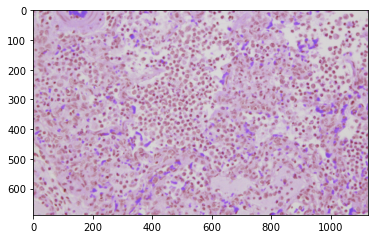

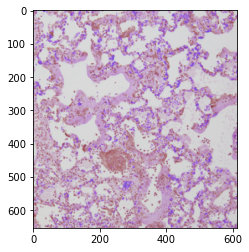

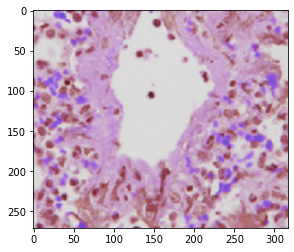

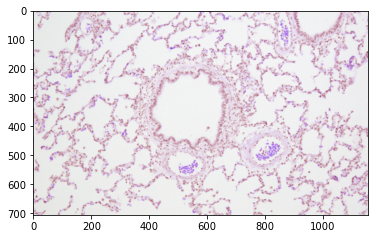

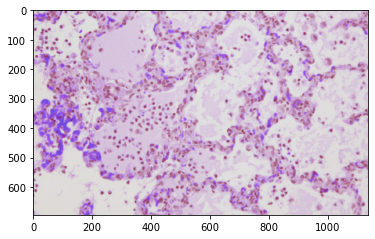

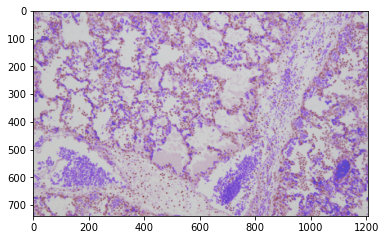

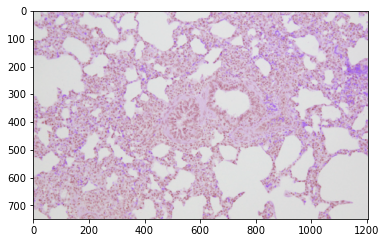

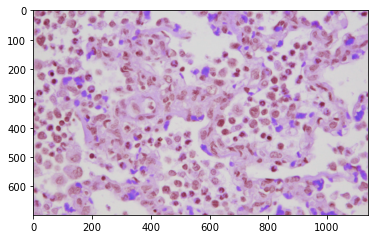

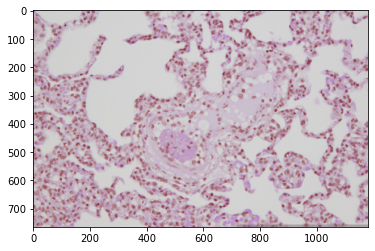

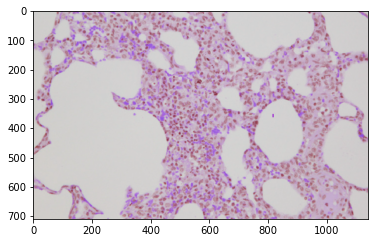

<Figure size 432x288 with 0 Axes>

In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
imgs = glob.glob('new_test/*.png')

for i in imgs:
    k = cv2.imread(i)
    plt.imshow(k)
    plt.figure()
    print(k.shape)
    print(i)

### cut into tiles of 224x224

In [ ]:
import math

for k in imgs:
    img = cv2.imread(k)
    print(img.shape)
    img_shape = img.shape
    tile_size = (224, 224)
    offset = (224, 224)
    img_name = k.split('\\')[1]
    fig = plt.figure(figsize = (20,20))
    plt.imshow(img)

   
    for i in range(int(math.floor(img_shape[0]/(offset[1] * 1.0)))):
        for j in range(int(math.floor(img_shape[1]/(offset[0] * 1.0)))):
            cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            name = img_name.replace('.png','__')
            if cropped_img.shape[0]<tile_size[0] or cropped_img.shape[1]<tile_size[1]:
                shape = np.shape(cropped_img)
                zero_pad_cropped_img=np.ones((224,224,3),dtype=int)*255
                zero_pad_cropped_img[:shape[0],:shape[1]]=cropped_img
                cv2.imwrite("cropped_imgs/"+ name + str(i) + "_" + str(j) + ".png", zero_pad_cropped_img)
                fig.tight_layout() 
            else:    
                cv2.imwrite("cropped_imgs/"+ name + str(i) + "_" + str(j) + ".png", cropped_img)
                fig.tight_layout()

    

In [ ]:
## libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Flatten, Input, MaxPooling2D, Activation, BatchNormalization, Concatenate, Dropout, Add, Dense,LeakyReLU
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.models import model_from_json
from myplot import multi_plot
from pathlib import Path
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Lambda
from keras.models import Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from pathlib import Path
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.models import model_from_json
from myplot import multi_plot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import InputSpec, Layer

import pandas as pd
from sklearn.metrics import classification_report
from keras.models import Model, model_from_json

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB4,EfficientNetB7
import os
##https://neptune.ai/blog/keras-metrics
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall

In [ ]:
## model and function used in model definition
#######################################################################################################
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

## Model definition
#################################################################################################################################
def pretrained_model_func(img_shape, num_classes,layer_type):
    model_conv = EfficientNetB4(weights='imagenet', include_top=False)

    #Input format
    keras_input = Input(shape=(224,224,3), name = 'image_input')
    
    #Use the generated model 
    output_conv = model_conv(keras_input)
    
    for layer in model_conv.layers:
        layer.trainable = False
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(128, activation=layer_type, name='fc1')(x)
    x = Dense(128, activation=layer_type, name='fc2')(x)
    x = Dropout(0.5, name='dropout')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    METRICS = [
      keras.metrics.SparseCategoricalAccuracy(),
      MulticlassTruePositives()]
    
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=METRICS)
    #pretrained_model.summary()

    return pretrained_model


### Prediction

In [ ]:
#######################################################################
model_name       = 'EffnetB4_man_aug_1st'  ## different model
validation_DATA_PATH  =  'cropped_imgs/'
input_shape = (224,224,3)

In [ ]:
validation_images = glob.glob(validation_DATA_PATH+'*.png')
n_v= len(validation_images) 
print(n_v)
validation_samples = np.zeros((n_v, input_shape[0], input_shape[1], 3), dtype=np.float32)
image_names = []



for ctr,line in zip(range(n_v),validation_images):
    validation_samples[ctr,:,:,:] = cv2.imread(line)
    image_names.append(line.split('\\')[-1])  


for i in range(n_v):
    mod_img = validation_samples[i,:, :].astype(np.float32)
    validation_samples[i, :, :, :] = mod_img

    
pretrained_model = pretrained_model_func(input_shape, 3,'relu') ## REGRESSION: number of classes 1 instead of 3
weights =glob.glob('../../../relu_previous/effnet_aug_3fold_90_rotation/1st_part_best_weights.12-0.88.hdf5')
print(weights)
# Load weights, select between best_weights (val_accuracy) and final_weights from last epoch
pretrained_model.load_weights(weights[0])

# Make predictions on validation samples
preds = pretrained_model.predict(validation_samples)

# Max predictions in numpy array
y_pred = np.argmax(preds,axis=1)  # 0,1 or 2
x_l = range(len(y_pred))

################################################################
### Here all predicted labels are saved in the following file

with open('cropped_imgs/'+model_name+'_'+'_validation_predicted_newlabels.txt','w') as fout: 
    for i,line in zip(y_pred,image_names):
        print(line,np.int(i),sep=' ',file=fout)
    fout.close()

In [23]:
from statistics import mode
with open('cropped_imgs/EffnetB4_man_aug_agg__validation_predicted_newlabels.txt','w') as fg:
    with open('cropped_imgs/EffnetB4_man_aug_ensembled__validation_predicted_newlabels.txt','w') as ft:
        with open('cropped_imgs/EffnetB4_man_aug_1st__validation_predicted_newlabels.txt','r') as f1:
                with open('cropped_imgs/EffnetB4_man_aug_2nd__validation_predicted_newlabels.txt','r') as f2:
                    with open('cropped_imgs/EffnetB4_man_aug_3rd__validation_predicted_newlabels.txt','r') as f3:
                        for l1,l2,l3 in zip(f1,f2,f3):
                            tile_name = l1.split()[0]
                            p_s_1 = l1.split()[1]
                            p_s_2 = l2.split()[1]
                            p_s_3 = l3.split()[1]
                            print(tile_name,p_s_1,p_s_2,p_s_3,sep=' ',file = ft)
                            print(tile_name,mode([p_s_1,p_s_2,p_s_3]),sep=' ',file = fg)
                            


#### EffnetB4_man_aug fold1,fold2, fold3 ensembled 
#### plotting prediction as grey colors on top of main images

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from pathlib import Path
from PIL import Image
import os


from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import Callback
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout,LeakyReLU
from keras.models import Model, model_from_json

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix




validation_DATA_PATH  = 'cropped_imgs/'
validation_COLORED_PATH  = 'colored_imgs/'
validtion_ORIGINAL_PATH  = 'NEW_test/'


f_orig = glob.glob(validtion_ORIGINAL_PATH+'/*.png')

tile_index = ''
score_class = {'0':'low','1':'medium','2':'high'}
for line in f_orig:
    main_img_size      = cv2.imread(line).shape
    main_img           = cv2.imread(line).astype(np.float32)
    #color_score_matrix = np.ones([main_img_size[0],main_img_size[1],3])
    color_score_matrix = np.zeros([int(np.floor(main_img_size[0]/224)*224),int(np.floor(main_img_size[1]/224)*224),3])
              
    main_img_name      = line.replace('.png','').split('\\')[-1]
    with open(validation_DATA_PATH+'EffnetB4_man_aug_agg__validation_predicted_newlabels.txt','r') as f_pred:
        caption = []
        for line_pred in f_pred:
            tile_index    = line_pred.split()[0].split('__')[0]
            if tile_index == main_img_name:
                tile_row  = int(line_pred.split()[0].split('__')[1].replace('.png','').split('_')[0])
                tile_col  = int(line_pred.split()[0].split('__')[1].replace('.png','').split('_')[1])
                temp_score = int(line_pred.split()[1])
                if temp_score==0:
                    r_ =0
                    g_ =0
                    b_ =0
                elif temp_score ==1:
                    r_ = 1
                    g_ = 1
                    b_ = 1
                else:
                    r_ = 2
                    g_ = 2
                    b_ = 2
                color_score_matrix[tile_row*224:(tile_row+1)*224,tile_col*224:(tile_col+1)*224,0]= 60*r_
                color_score_matrix[tile_row*224:(tile_row+1)*224,tile_col*224:(tile_col+1)*224,1]= 60*g_
                color_score_matrix[tile_row*224:(tile_row+1)*224,tile_col*224:(tile_col+1)*224,2]= 60*b_
                caption.append(score_class[line_pred.split()[1]])

            else:
                continue
   
    sh      =         np.shape(color_score_matrix)
    main_tiles_scored =main_img[0:sh[0],0:sh[1],:]-color_score_matrix
    main_tiles_scored  = np.clip(main_tiles_scored,0,255)
    main_tiles_scored /=255
                
    #super_imposed_img = cv2.addWeighted(main_img.astype(np.uint8), 0.7, color_score_matrix.astype(np.uint8), 0.3,0)
    plt.figure()
    plt.title('predicted class:{}'.format(caption))
    plt.imshow(main_tiles_scored)
    caption = []

    
    

In [16]:
from statistics import mode
with open('cropped_imgs/EffnetB4_rnd_aug_agg__validation_predicted_newlabels.txt','w') as fg:
    with open('cropped_imgs/EffnetB4_rnd_aug_ensembled__validation_predicted_newlabels.txt','w') as ft:
        with open('cropped_imgs/EffnetB4_rnd_aug_1st__validation_predicted_newlabels.txt','r') as f1:
                with open('cropped_imgs/EffnetB4_rnd_aug_2nd__validation_predicted_newlabels.txt','r') as f2:
                    with open('cropped_imgs/EffnetB4_rnd_aug_3rd__validation_predicted_newlabels.txt','r') as f3:
                        for l1,l2,l3 in zip(f1,f2,f3):
                            tile_name = l1.split()[0]
                            p_s_1 = l1.split()[1]
                            p_s_2 = l2.split()[1]
                            p_s_3 = l3.split()[1]
                            print(tile_name,p_s_1,p_s_2,p_s_3,sep=' ',file = ft)
                            print(tile_name,mode([p_s_1,p_s_2,p_s_3]),sep=' ',file = fg)
                            


In [17]:
from statistics import mode
with open('cropped_imgs/Vgg16_rnd_aug_agg__validation_predicted_newlabels.txt','w') as fg:
    with open('cropped_imgs/Vgg16_rnd_aug_ensembled__validation_predicted_newlabels.txt','w') as ft:
        with open('cropped_imgs/Vgg16_rnd_aug_1st__validation_predicted_newlabels.txt','r') as f1:
                with open('cropped_imgs/Vgg16_rnd_aug_2nd__validation_predicted_newlabels.txt','r') as f2:
                    with open('cropped_imgs/Vgg16_rnd_aug_3rd__validation_predicted_newlabels.txt','r') as f3:
                        for l1,l2,l3 in zip(f1,f2,f3):
                            tile_name = l1.split()[0]
                            p_s_1 = l1.split()[1]
                            p_s_2 = l2.split()[1]
                            p_s_3 = l3.split()[1]
                            print(tile_name,p_s_1,p_s_2,p_s_3,sep=' ',file = ft)
                            print(tile_name,mode([p_s_1,p_s_2,p_s_3]),sep=' ',file = fg)
                           

In [31]:
from statistics import mode
with open('cropped_imgs/T_3_t_agg__validation_predicted_newlabels.txt','w') as fg:
    with open('cropped_imgs/T_3_t_ensembled__validation_predicted_newlabels.txt','w') as ft:
        with open('cropped_imgs/Vgg16_rnd_aug_ensembled__validation_predicted_newlabels.txt','r') as f1:
                with open('cropped_imgs/EffnetB4_man_aug_ensembled__validation_predicted_newlabels.txt','r') as f2:
                    with open('cropped_imgs/EffnetB4_rnd_aug_ensembled__validation_predicted_newlabels.txt','r') as f3:
                        for l1,l2,l3 in zip(f1,f2,f3):
                            tile_name = l1.split()[0]
                            p_s_1 = l1.split()[1:]
                            p_s_2 = l2.split()[1:]
                            p_s_3 = l3.split()[1:]
                            all_scores_list  = p_s_1+p_s_2+p_s_3
                           
                            print(tile_name,*all_scores_list,file = ft)
                            
                            print(tile_name,mode(p_s_1+p_s_2+p_s_3),sep=' ',file = fg)
                           